In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# Training a CNN from scratch on a small dataset (using Data Augmentation)

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice.

As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 
pictures for training, 1000 for validation, and finally 1000 for testing.

## Methods to be applied
1. training a new model from scratch (This program)
2. data augmentation, a powerful technique for mitigating overfitting (This program)
3. doing feature extraction with a pre-trained network (2 methods)
4. fine-tuning a pre-trained network


## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. 

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). 

We are using much smaller dataset with only 4,000. 

First `**Add to My Drive**` the following Google folder:

[cats_dogs_original_sm](https://drive.google.com/drive/folders/1Vzm1qylSqu-YqNOhJ4B0b2jyTVS4gqJY?usp=sharing)

If you are using LTU gmail account, you should be able to access the folder. If you are not using LTU gmail, then send cchung@ltu.edu an email. Then I will share the folder with you using your email address.

### To access your own datasets on Google Drive in Colab 

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
!ls /gdrive/"My Drive"

 Bibliography.gdoc	       'Lab1Shell for Online_Students.zip'
 cats_dogs_original_sm	        Lab2Shell__Student_DH_2013.zip
'Colab Notebooks'	       'Machiavellian Philosophy.gdoc'
'<Game Design Document>.gdoc'  'Machiavelli Speech.gdoc'
'Getting started.pdf'	       'Paper Coin Presentation.gslides'
'Homework 3.gdoc'	       'Scripting HW1.gdoc'
'Homework Week 11.gdoc'        'Scripting HW 2.gdoc'
 hw3_2.scm		       'Scripting HW5.gdoc'
 JavaScript.gslides	        WindowsCalculatorProgram.zip


In [4]:
!ls -l /gdrive/"My Drive"/cats_dogs_original_sm # Note that you might not have "DL_data"

total 12
dr-x------ 2 root root 4096 Oct 13  2018 test
dr-x------ 2 root root 4096 Oct 13  2018 train
dr-x------ 2 root root 4096 Oct 13  2018 validation


In [0]:
# Directories
train_dir =      '/gdrive/My Drive/cats_dogs_original_sm/train'
validation_dir = '/gdrive/My Drive/cats_dogs_original_sm/validation'
test_dir =       '/gdrive/My Drive/cats_dogs_original_sm/test'

train_cats_dir =      '/gdrive/My Drive/cats_dogs_original_sm/train/cats'
train_dogs_dir =      '/gdrive/My Drive/cats_dogs_original_sm/train/dogs'
validation_cats_dir = '/gdrive/My Drive/cats_dogs_original_sm/validation/cats'
validation_dogs_dir = '/gdrive/My Drive/cats_dogs_original_sm/validation/dogs'
test_cats_dir =       '/gdrive/My Drive/cats_dogs_original_sm/test/cats'
test_dogs_dir =       '/gdrive/My Drive/cats_dogs_original_sm/test/dogs'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [6]:
import os, shutil
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

* Since we are dealing with bigger images and a more complex problem (compared to the MNIST problem), we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. 

* This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

* Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

* Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss. **For more info, please go to [this DLology page](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)**

In [9]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), # learning rate
              metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps **automatically**. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the target directory
        target_size=(150, 150), # All images will be resized to 150x150
        batch_size=20, # a batch with 20 images
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


As an **example** of using the train_generator, let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [11]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [0]:
#print(data_batch)

Let's fit (train) our model to the data using `fit_generator` method, the equivalent of `fit` for data generators. 

It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When you pass a generator as `validation_data` for validation, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, # 20 (batch_size) x 100 = 2,000 train samples
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50 # 20 (batch_size) x 50 = 1,000 validation samples
)




Epoch 1/10





100/100 [==============================] - 1365s 14s/step - loss: 0.6840 - acc: 0.5430 - val_loss: 0.6653 - val_acc: 0.5770
Epoch 2/10
100/100 [==============================] - 13s 126ms/step - loss: 0.6441 - acc: 0.6100 - val_loss: 0.6264 - val_acc: 0.6550
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.5866 - acc: 0.6955 - val_loss: 0.6146 - val_acc: 0.6430
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 0.5580 - acc: 0.7120 - val_loss: 0.6183 - val_acc: 0.6540
Epoch 5/10
100/100 [==============================] - 12s 123ms/step - loss: 0.5361 - acc: 0.7240 - val_loss: 0.6021 - val_acc: 0.6640
Epoch 6/10
100/100 [==============================] - 13s 130ms/step - loss: 0.5164 - acc: 0.7450 - val_loss: 0.5848 - val_acc: 0.6820
Epoch 7/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4919 - acc: 0.7615 - val_loss: 0.5800 - val_acc: 0.7020
Epoch 8/10
100/100 [===========================

It is good practice to always save your models after training:

In [0]:
model.save('cats_and_dogs_small_1.h5') # saved in VM

In [0]:
import matplotlib.pyplot as plt

Let's plot the loss and accuracy of the model over the training and validation data during training:

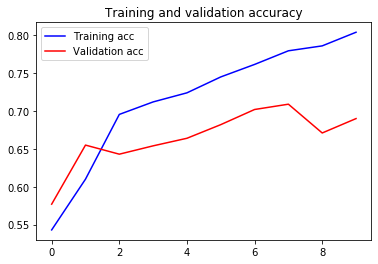

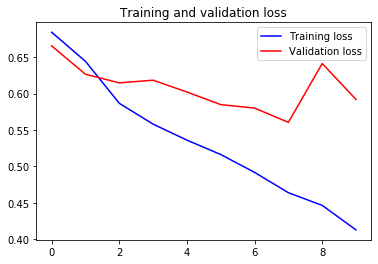

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting...


![alt text](https://miro.medium.com/max/700/1*_7OPgojau8hkiPUiHoGK_w.png)
![alt text](https://miro.medium.com/max/700/1*JZbxrdzabrT33Yl-LrmShw.png)

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. To mitigate overfitting, we will be using:

- dropout - setting output of some neurons to zero
- weight decay (L2 regularization) - after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large.
-  **data augmentation** - specific to computer vision, and used almost universally when processing images with deep learning models:

## Using Data Augmentation (DA)

* Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. 

* Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. **The goal is that at training time for each epoch, our model would never see the exact same 
image twice**. This helps the model get exposed to more aspects of the data and generalize better.

* In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. 

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations. [See this](http://scilabipcv.tritytech.com/2017/06/26/affine-transformation-shearing/)
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at some of our augmented images:

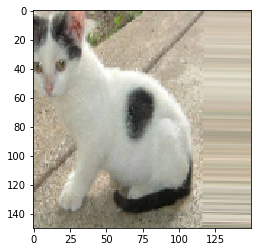

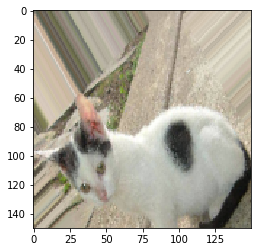

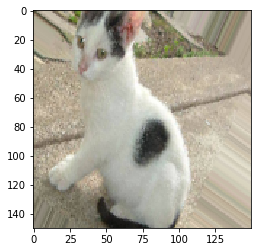

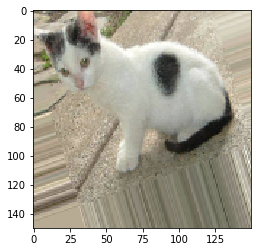

In [18]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

#plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might **not be quite enough to completely get rid of overfitting**. To further fight 
overfitting, we will also add a **Dropout** layer to our model, right before the densely-connected classifier:

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # <====== new
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let's train our network using data augmentation and dropout:

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(     
        train_dir, # This is the target directory
        target_size=(150, 150), # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
# This is not needed here. Do not need to retest the train_generator
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [22]:
history = model.fit_generator(
      train_generator, # never see same image, for each epoch
      steps_per_epoch=100, # 20 x 100 = 2000 samples for an epoch
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50) # 20 (batch_size) x 50 = 1,000 validation samples

Epoch 1/30
100/100 [==============================] - 23s 235ms/step - loss: 0.6901 - acc: 0.5240 - val_loss: 0.6750 - val_acc: 0.5740
Epoch 2/30
100/100 [==============================] - 21s 211ms/step - loss: 0.6792 - acc: 0.5570 - val_loss: 0.6654 - val_acc: 0.5860
Epoch 3/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6662 - acc: 0.5840 - val_loss: 0.6627 - val_acc: 0.5860
Epoch 4/30
100/100 [==============================] - 21s 210ms/step - loss: 0.6477 - acc: 0.6225 - val_loss: 0.6422 - val_acc: 0.6180
Epoch 5/30
100/100 [==============================] - 21s 209ms/step - loss: 0.6366 - acc: 0.6345 - val_loss: 0.6263 - val_acc: 0.6300
Epoch 6/30
100/100 [==============================] - 21s 209ms/step - loss: 0.6288 - acc: 0.6480 - val_loss: 0.5950 - val_acc: 0.6770
Epoch 7/30
100/100 [==============================] - 21s 213ms/step - loss: 0.6064 - acc: 0.6700 - val_loss: 0.5851 - val_acc: 0.6720
Epoch 8/30
100/100 [==============================] - 2

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5') # saved on VM

Let's plot our results again:

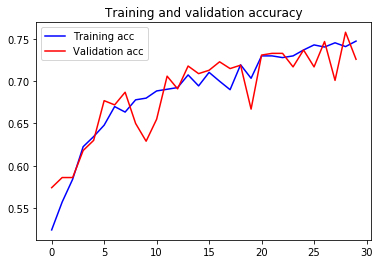

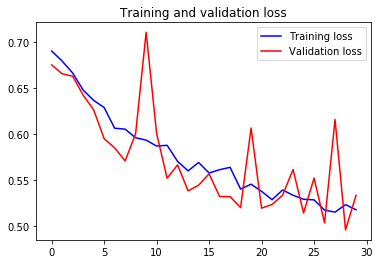

In [24]:
acc2 = history.history['acc']
val_acc2 = history.history['val_acc']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(len(acc2))

plt.plot(epochs, acc2, 'b', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'b', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Thanks to data augmentation and dropout, the training curves are rather closely tracking the validation curves. We have now better accuary, too.

Next step to improve our accuracy on this problem: using a pre-trained model.

## Evaluation: Display some Test images and present them to the model. Check the results

In [25]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [26]:
# To get the 1st batch
for t_data_batch, t_labels_batch in train_generator:
    print('data batch shape:', t_data_batch.shape)
    print('labels batch shape:', t_labels_batch.shape)
    break # try this for loop without "break"

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


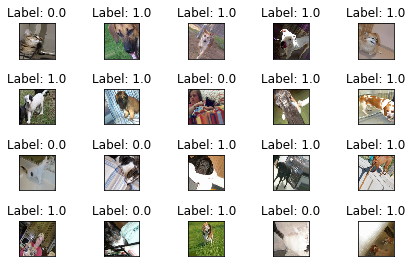

In [27]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(t_data_batch[i],interpolation='none')
  plt.title("Label: {}".format(t_labels_batch[i]))
  plt.xticks([])
  plt.yticks([])

In [28]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = model.predict(t_data_batch) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
prediected labels:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]


In [29]:
# To get the 2nd batch
for t_data_batch, t_labels_batch in train_generator:
    print('data batch shape:', t_data_batch.shape)
    print('labels batch shape:', t_labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [30]:
print("target labels:     ", t_labels_batch)
# present the image to the network
out = model.predict(t_data_batch) 
out = out.reshape(20,)
print("prediected labels: ", out.round())

target labels:      [0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
prediected labels:  [0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.]


## HW8: Test this program with different DA parameters

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # <====== new
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), # learning rate
              metrics=['acc'])

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',)

train_generator = train_datagen.flow_from_directory(     
        train_dir, # This is the target directory
        target_size=(150, 150), # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, # 20 (batch_size) x 100 = 2,000 train samples
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50 # 20 (batch_size) x 50 = 1,000 validation samples
)

Epoch 1/30
100/100 [==============================] - 24s 242ms/step - loss: 0.6193 - acc: 0.6510 - val_loss: 0.5864 - val_acc: 0.7020
Epoch 2/30
100/100 [==============================] - 22s 220ms/step - loss: 0.6183 - acc: 0.6490 - val_loss: 0.5822 - val_acc: 0.6990
Epoch 3/30
100/100 [==============================] - 22s 217ms/step - loss: 0.6186 - acc: 0.6560 - val_loss: 0.5769 - val_acc: 0.7030
Epoch 4/30
100/100 [==============================] - 22s 221ms/step - loss: 0.6084 - acc: 0.6640 - val_loss: 0.5934 - val_acc: 0.6860
Epoch 5/30
100/100 [==============================] - 22s 222ms/step - loss: 0.5997 - acc: 0.6655 - val_loss: 0.6181 - val_acc: 0.6560
Epoch 6/30
100/100 [==============================] - 23s 227ms/step - loss: 0.6038 - acc: 0.6740 - val_loss: 0.6551 - val_acc: 0.6660
Epoch 7/30
100/100 [==============================] - 22s 224ms/step - loss: 0.5984 - acc: 0.6765 - val_loss: 0.5799 - val_acc: 0.6960
Epoch 8/30
100/100 [==============================] - 2

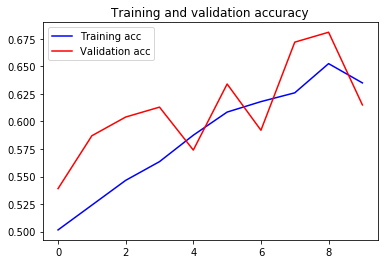

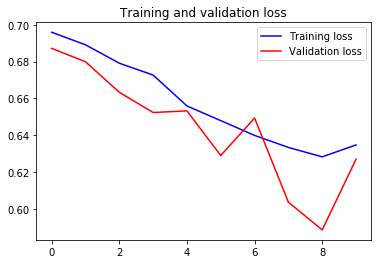

In [34]:
acc3 = history.history['acc']
val_acc3 = history.history['val_acc']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

epochs = range(len(acc3))

plt.plot(epochs, acc3, 'b', label='Training acc')
plt.plot(epochs, val_acc3, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'b', label='Training loss')
plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

After adjusting the pre-processing of the images, the training and validation suffered more loss than before. So the change was worse.

## Future Task: display images that failed in the binary classification